# 1. Cleaning Data

Here we are investigating the data on Drone attacks that have happened in Pakistan since 2004.

In [276]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [277]:
# Reading the data
df = pd.read_csv("/Users/harshitsrivastava/Desktop/Data/PakistanDroneAttacks.csv")

# Removing the last row as it contained junk values
df = df.drop(df.index[[403, 404]])

# Dropiing the Axes that are not required
df=df.drop(['Special Mention (Site)', 'Comments', 'References'], axis=1)

# Printing the number of missing values in the data
for col in df:
    print col, ": ", df[col].isnull().sum()

S# :  0
Date :  0
Time :  230
Location :  0
City :  0
Province :  0
No of Strike :  0
Al-Qaeda :  307
Taliban :  264
Civilians Min :  68
Civilians Max :  45
Foreigners Min :  312
Foreigners Max :  265
Total Died Min :  97
Total Died Mix :  3
Injured Min :  259
Injured Max :  128
Women/Children   :  68
Longitude :  0
Latitude :  0
Temperature(C) :  2
Temperature(F) :  2


### 1.1. Missing Values


Removing NaN values from columns and replacing it with appropriate values:
1. Time: NaN -> 00:00 (Setting un-recorded time to 12 AM)
2. Al-Qaeda TO Injured_Min: NaN -> 0 (Setting un-recorded deaths to 0)
3. Women/Children: NaN -> N (Setting un-recorded Women/Children involvement to No)
4. Location (City Name) NaN -> when location not recorded (Lattitude and longitude still present)

In [278]:
def filling_nan(data):
    
    col = ['Al-Qaeda', 'Taliban', 'Civilians Min', 'Civilians Max', 'Foreigners Min', 'Foreigners Max', 
           'Total Died Min', 'Total Died Mix', 'Injured Min', 'Injured Max']
    
    data['Time'] = data['Time'].fillna('00:00')                      # Filling Time column's missing values with 00:00
    data[col] = data[col].fillna(0)                                  # Filling the above columns with 0
    data['Women/Children  '] = data['Women/Children  '].fillna('N')  # Filling the Women/Children column's missing values with 'N'
    data['Temperature(C)'] = data['Temperature(C)'].fillna(data['Temperature(C)'].mean())
    data['Temperature(F)'] = data['Temperature(F)'].fillna(data['Temperature(F)'].mean())
    
    return data

In [279]:
data = filling_nan(df)

# Printing the number of missing values in the data
for col in df:
    print col, ": ", df[col].isnull().sum()

S# :  0
Date :  0
Time :  0
Location :  0
City :  0
Province :  0
No of Strike :  0
Al-Qaeda :  0
Taliban :  0
Civilians Min :  0
Civilians Max :  0
Foreigners Min :  0
Foreigners Max :  0
Total Died Min :  0
Total Died Mix :  0
Injured Min :  0
Injured Max :  0
Women/Children   :  0
Longitude :  0
Latitude :  0
Temperature(C) :  0
Temperature(F) :  0


### Changing to Date-Time format

Merging the Date and Time columns and saving the data in date-time format for ease of use

In [280]:
def dt(data):
    data['DateTime'] = pd.Series()
    for i in range(0, len(data.Date)):
        
        # Appending the Date and Time field to 'frame' and creating a new column based on the specified Date-time format
        frame = data['Date'][i] + ', ' + data['Time'][i]
        data['DateTime'][i] = frame
        data['DateTime'][i] =  datetime.strptime(data['DateTime'][i], '%A, %B %d, %Y, %H:%M')
    
    return data

In [281]:
data = dt(data)

/Users/harshitsrivastava/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/harshitsrivastava/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Marking terrorists and civilians

In the dataset, there are separate columns for no. of Al-Qaeda personnel killed, no. of Talibani killed, minimum no. of civilians killed etc. We want to add a new column marking the count of a terrorist killed (Al-Qaeda or Taliban) and marking the counts of civilians killed (civilians, foreigners etc.)

In [282]:
data['Terrorists'] = data['Al-Qaeda'] + data['Taliban']                   # Adding Taliban and Al-Qaeda personnel killed
data['Civilians'] = (data['Civilians Min'] + data['Civilians Max'])/2     # Taking average of Max and Min Civilians killed
data['Civilians'] = np.ceil(data['Civilians'])                            # Rounding up the average
data['Injured'] = (data['Injured Min'] + data['Injured Max'])/2           # Taking average of Max and Min Civilians injured
data['Injured'] = np.ceil(data['Injured'])                                # Rounding up the average
data['Total Died'] = (data['Total Died Min'] + data['Total Died Mix'])/2           # Taking average of Max and Min Civilians injured
data['Total Died'] = np.ceil(data['Total Died'])
data['Foreigners'] = (data['Foreigners Min'] + data['Foreigners Max'])/2  # Taking average of Max and Min Foreigners killed
data['Foreigners'] = np.ceil(data['Foreigners'])                          # Rounding up the average

data['Innocents'] = data['Total Died'] - data['Terrorists']                # Marking all the non-terrorists killed


# In some observations, the Total Died was not calculated accurately and there were negative values representing the 
# number of people killed. In those cases, we used different method to calculate the Civilian Casualties
for i in range(0, len(data.Innocents)):
    if data['Innocents'][i] <0:
        data['Innocents'][i] = data['Civilians'][i] + data['Foreigners'][i]
        
    # Changing the Labels in 'Women/Children' column to Binary values
    if data['Women/Children  '][i] == 'N':
        data['Women/Children  '][i] = 0
    elif data['Women/Children  '][i] == 'Y':
        data['Women/Children  '][i] = 1

# Accuracy is defined as the ratio of terrorists killed to the total number of people killed in a drone strike
data['Accuracy'] = (data['Terrorists'])/(data['Terrorists'] + data['Innocents'])
data['Accuracy'] = data['Accuracy'].fillna(0)

/Users/harshitsrivastava/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/harshitsrivastava/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/harshitsrivastava/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [283]:
data

,S#,Date,Time,Location,City,Province,No of Strike,Al-Qaeda,Taliban,Civilians Min,...,Temperature(C),Temperature(F),DateTime,Terrorists,Civilians,Injured,Total Died,Foreigners,Innocents,Accuracy
0,1.0,"Friday, June 18, 2004",22:00,Near Wana,south Waziristan,FATA,1.0,0.0,1.0,0.0,...,28.475000,83.255000,2004-06-18 22:00:00,1.0,2.0,0.0,3.0,0.0,2.0,0.333333
1,2.0,"Sunday, May 08, 2005",23:30,Mir Ali (Near Afghan Border),North Waziristan,FATA,1.0,1.0,0.0,0.0,...,11.475000,52.655000,2005-05-08 23:30:00,1.0,1.0,0.0,1.0,0.0,0.0,1.000000
2,3.0,"Thursday, December 01, 2005",00:00,Haisori- Miran Shah,North Waziristan,FATA,1.0,1.0,0.0,0.0,...,7.080000,44.744000,2005-12-01 00:00:00,1.0,1.0,1.0,3.0,2.0,2.0,0.333333
3,4.0,"Friday, January 06, 2006",00:00,Saidgai village- 115km north of Wana,North Waziristan,FATA,1.0,0.0,0.0,0.0,...,0.535000,32.963000,2006-01-06 00:00:00,0.0,0.0,1.0,2.0,0.0,2.0,0.000000
4,5.0,"Friday, January 13, 2006",3:00,Damadola Village,Bajaur Agency,FATA,1.0,0.0,0.0,0.0,...,10.025000,50.045000,2006-01-13 03:00:00,0.0,9.0,1.0,9.0,0.0,9.0,0.000000
5,6.0,"Monday, October 30, 2006",00:00,Chenagai,Bajaur Agency,FATA,1.0,0.0,0.0,0.0,...,18.120000,64.616000,2006-10-30 00:00:00,0.0,41.0,0.0,41.0,0.0,41.0,0.000000
6,7.0,"Friday, April 27, 2007",00:00,Saidgai village,North Waziristan,FATA,1.0,0.0,0.0,0.0,...,25.770000,78.386000,2007-04-27 00:00:00,0.0,1.0,1.0,2.0,1.0,2.0,0.000000
7,8.0,"Tuesday, June 19, 2007",10:30,MamiRogha- Dattakhel,North Waziristan,FATA,3.0,0.0,0.0,20.0,...,24.395000,75.911000,2007-06-19 10:30:00,0.0,26.0,8.0,26.0,0.0,26.0,0.000000
8,9.0,"Friday, November 02, 2007",00:00,Dandey darpakhel-Miranshah,North Waziristan,FATA,1.0,0.0,0.0,5.0,...,15.325000,59.585000,2007-11-02 00:00:00,0.0,7.0,9.0,8.0,1.0,8.0,0.000000
9,10.0,"Monday, December 03, 2007",00:00,Jani Khel,Bannu,KPK,1.0,0.0,0.0,0.0,...,13.790000,56.822000,2007-12-03 00:00:00,0.0,0.0,1.0,0.0,0.0,0.0,0.000000


# 2. Visualizing the given data

### Grouping the attacks by Year, Month and Day of Week

Making a new column for the year and grouping them by the Year to plot on a bar graph. 

In [284]:
# Creating new columns for Year, Day of week and Month from the given Date-Time format
data['Year'] = np.nan
data['Weekday'] = np.nan
data['Month'] = np.nan

# Extracting the Year of attack, Day of attack and the month of Attack
for i in range(0, len(data.Year)):
    data.loc[:,'Year'][i]= data.loc[:,'DateTime'][i].year
    data.loc[:,'Weekday'][i] = data['DateTime'][i].weekday()
    data.loc[:,'Month'][i] = data['DateTime'][i].month
    
# Grouping the new column by the Year, Weekday & Month and corresponding Drone Attacks
by_year = data.groupby(['Year'])['No of Strike'].sum()
by_weekday = data.groupby(['Weekday'])['No of Strike'].sum()
by_month = data.groupby(['Month'])['No of Strike'].sum()


/Users/harshitsrivastava/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/harshitsrivastava/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/harshitsrivastava/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


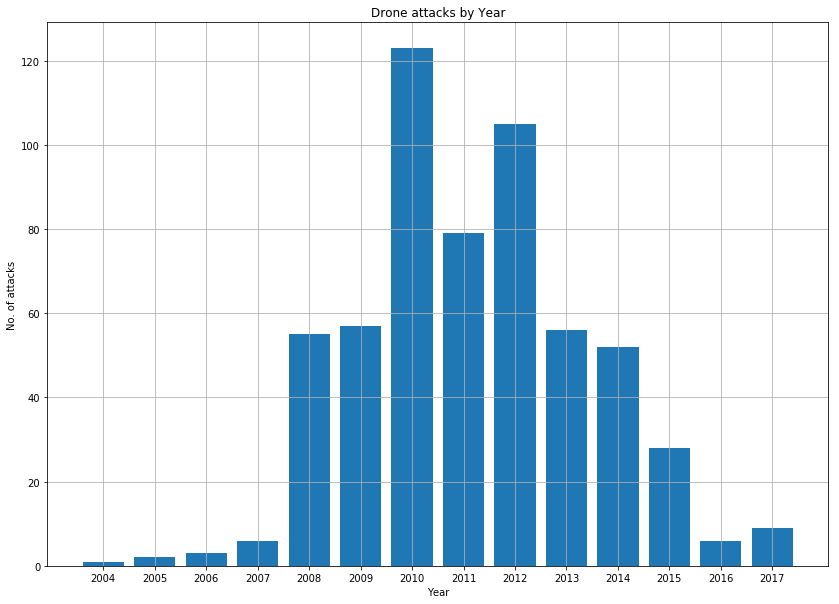

In [285]:
fig1 = plt.figure(figsize=(14, 10))
fig1 = plt.bar(left=list(by_year.keys()), height=by_year.values)
plt.xlabel("Year")
plt.ylabel("No. of attacks")
plt.title("Drone attacks by Year")
plt.xticks(range(2004, 2018))
plt.grid()
plt.show()

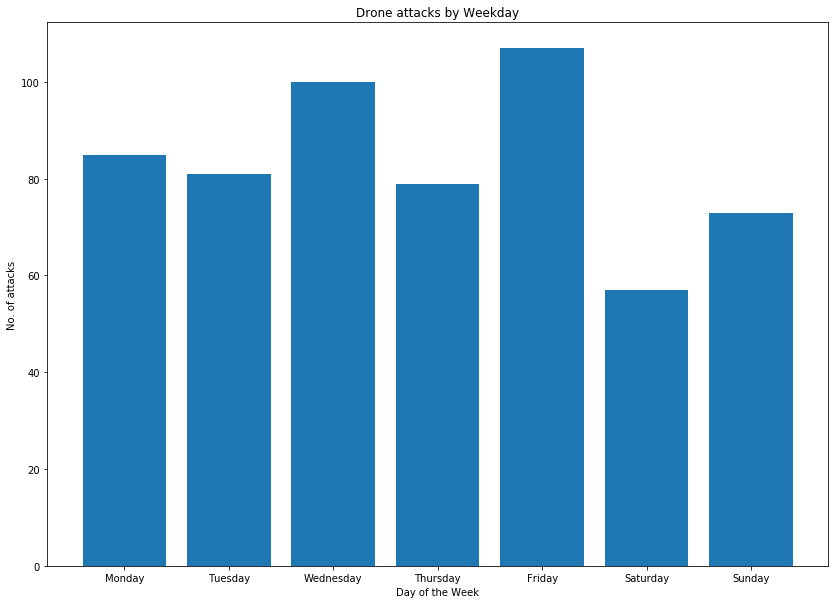

In [286]:
fig2 = plt.figure(figsize=(14, 10))
fig2 = plt.bar(left=list(by_weekday.keys()), height=by_weekday.values)
plt.xlabel("Day of the Week")
plt.ylabel("No. of attacks")
plt.title("Drone attacks by Weekday")
plt.xticks(range(0,7), ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'))
plt.show()

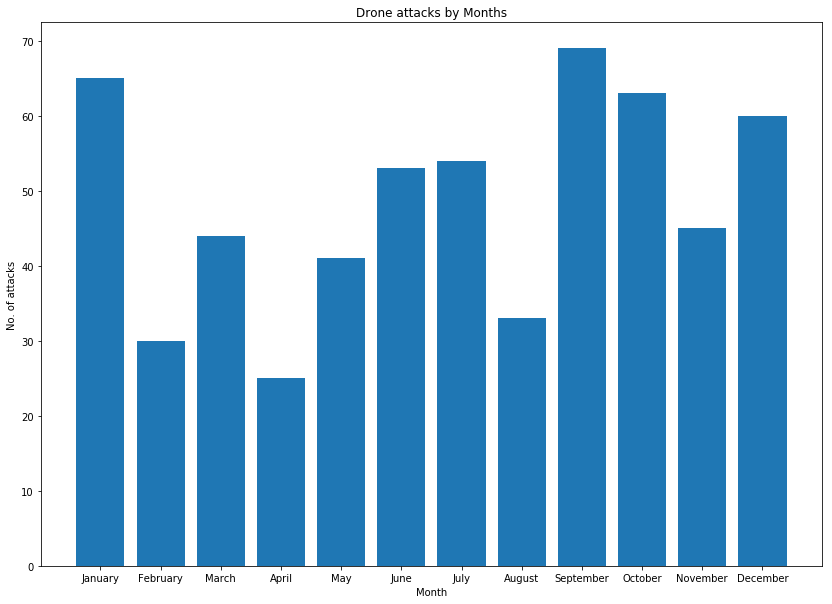

In [287]:
fig3 = plt.figure(figsize=(14, 10))
fig3 = plt.bar(left=list(by_month.keys()), height=by_month.values)
plt.xlabel("Month")
plt.ylabel("No. of attacks")
plt.title("Drone attacks by Months")
plt.xticks(range(1,13), ('January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'))
plt.show()

# 3. Attack Accuracy

Here, we are going to calculate the attack accuracy of the drone strikes i.e. the no. of terrorists killed divided by the number of civilians and foreigners killed. 

In [322]:
data_byyear = pd.DataFrame()
data_byyear['Terrorists'] = data.groupby(['Year'])['Terrorists'].sum()
data_byyear['Innocents'] = data.groupby(['Year'])['Innocents'].sum()
data_byyear['Injured'] = data.groupby(['Year'])['Injured'].sum()
data_byyear['No of strikes'] = data.groupby(['Year'])['No of Strike'].sum()
data_byyear['Al-Qaeda'] = data.groupby(['Year'])['Al-Qaeda'].sum()
data_byyear['Taliban'] = data.groupby(['Year'])['Taliban'].sum()
data_byyear['Foreigners'] = data.groupby(['Year'])['Foreigners'].sum()
data_byyear['Accuracy'] = data.groupby(['Year'])['Accuracy'].mean()
# Plotting the average Civilians killed in an attack
data_byyear['Avg Innocents Killed'] = data.groupby(['Year'])['Innocents'].mean()

In [323]:
data_byyear

,Terrorists,Innocents,Injured,No of strikes,Al-Qaeda,Taliban,Foreigners,Accuracy,Avg Innocents Killed
Year,,,,,,,,,
2004.0,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.333333,2.000000
2005.0,2.0,2.0,1.0,2.0,2.0,0.0,2.0,0.666667,1.000000
2006.0,0.0,52.0,2.0,3.0,0.0,0.0,0.0,0.000000,17.333333
2007.0,0.0,36.0,19.0,6.0,0.0,0.0,2.0,0.000000,9.000000
2008.0,36.0,270.0,113.0,55.0,11.0,25.0,52.0,0.075241,7.500000
2009.0,125.0,389.0,225.0,57.0,13.0,112.0,35.0,0.259694,7.780000
2010.0,111.0,701.0,285.0,123.0,1.0,110.0,53.0,0.122750,6.431193
2011.0,60.0,431.0,95.0,79.0,6.0,54.0,21.0,0.104892,5.904110
2012.0,87.0,204.0,64.0,105.0,7.0,80.0,30.0,0.231209,4.000000


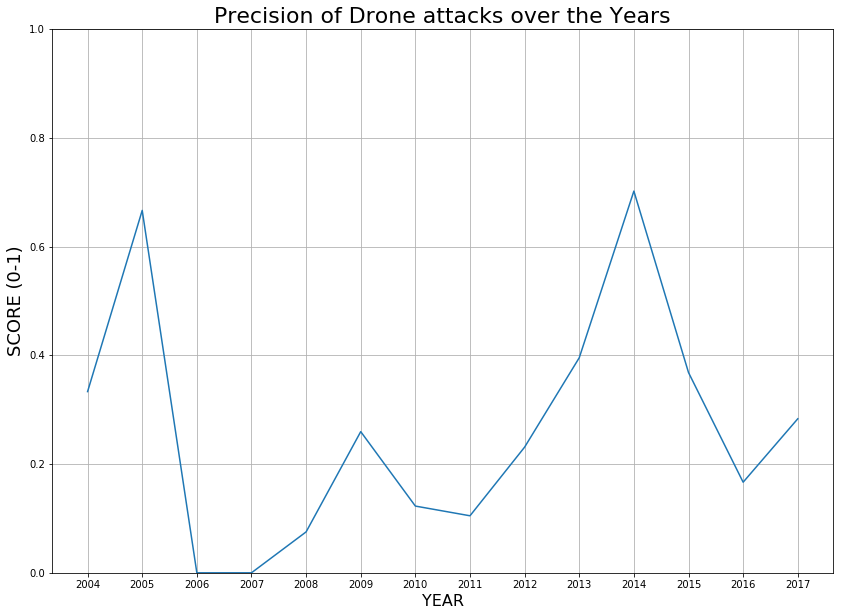

In [406]:
# Grouping the accuracy by Year and visualizing the accuracy trend over the years
#by_accuracy = data.groupby(['Year'])['Accuracy'].mean()

fig = plt.figure(figsize=(14, 10))
fig = plt.plot(data_byyear.Accuracy.keys(), data_byyear.Accuracy)
plt.xlabel("YEAR", fontsize=16)
plt.ylabel("SCORE (0-1)", fontsize=18)
plt.title("Precision of Drone attacks over the Years", fontsize=22)
plt.xticks(range(2004, 2018))
plt.ylim(0, 1)
plt.grid()
plt.show()

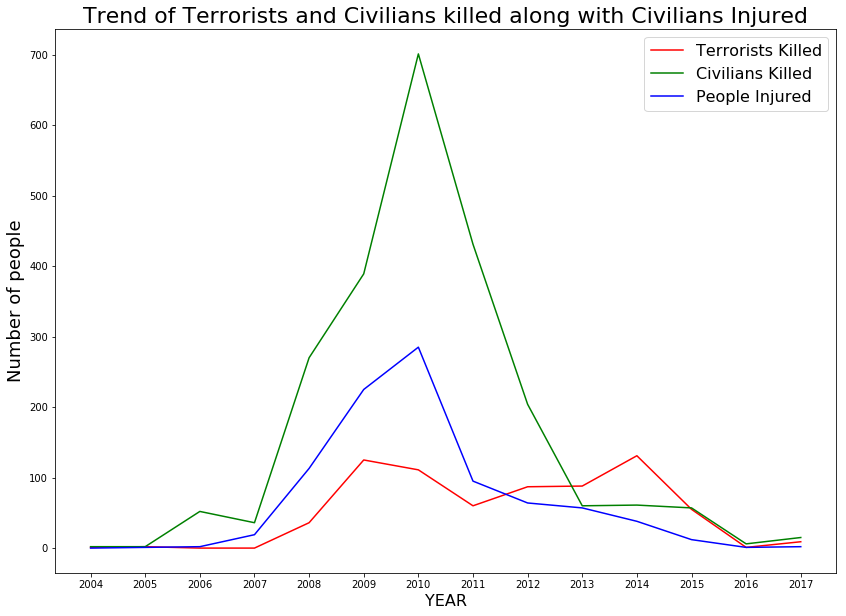

In [411]:
fig = plt.figure(figsize=(14, 10))
x = data_byyear.Accuracy.keys()

plt.plot(x, data_byyear.Terrorists, color='r', label = 'Terrorists Killed')
plt.plot(x, data_byyear.Innocents, color='g', label = 'Civilians Killed')
plt.plot(x, data_byyear.Injured, color='b', label = 'People Injured')
plt.xticks(range(2004, 2018))
plt.xlabel("YEAR", fontsize=16)
plt.ylabel("Number of people", fontsize=18)
plt.title("Trend of Terrorists and Civilians killed along with Civilians Injured", fontsize=22)
plt.legend(fontsize = 16)
plt.show()

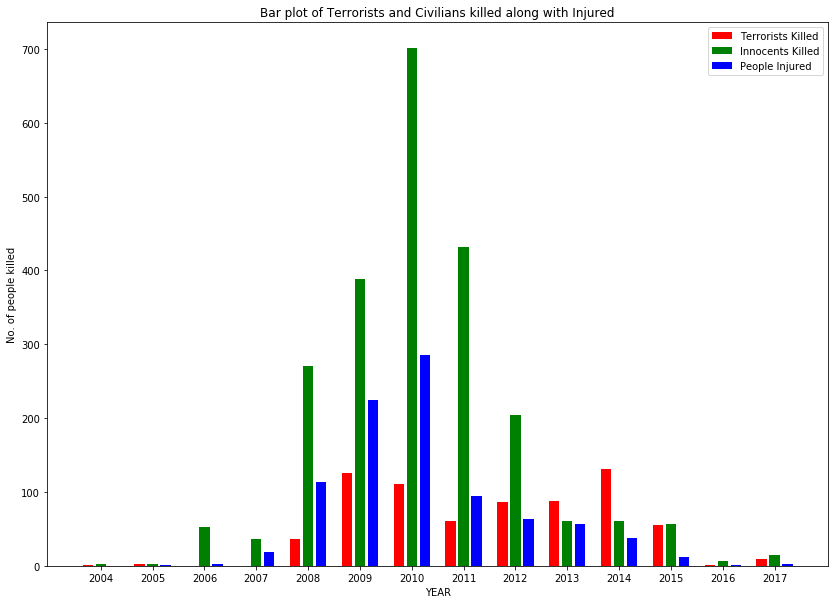

In [308]:
fig = plt.figure(figsize=(14, 10))
x = data_byyear.Accuracy.keys()

plt.bar(x - 0.25, data_byyear.Terrorists, width=0.2, color='r',align='center', label = 'Terrorists Killed')
plt.bar(x + 0.00, data_byyear.Innocents,width=0.2,color='g',align='center', label = 'Innocents Killed')
plt.bar(x + 0.25, data_byyear.Injured,width=0.2,color='b',align='center', label = 'People Injured')
plt.ylim(ymin=0)
plt.xticks(range(2004, 2018))
plt.xlabel("YEAR")
plt.ylabel("No. of people killed")
plt.title("Bar plot of Terrorists and Civilians killed along with Injured")
plt.legend()
plt.show()

# 4. Models

## Decision Tree

In [311]:
from sklearn.model_selection import train_test_split
from sklearn import tree

model_data=data.drop(['S#', 'Date', 'Time', 'Location', 'City', 'Province', 'DateTime'], axis=1)

## Creating Train and Test Dataset
train_df, test_df = train_test_split(model_data, test_size=0.2)

## Creating Features and Target data
y_train=train_df['Accuracy'].values                    # Target
x_train=train_df.drop('Accuracy', axis=1).values       # Features

y_test=test_df['Accuracy'].values                      # Target
x_test=test_df.drop('Accuracy', axis=1).values         # Features

cls=tree.DecisionTreeRegressor()   # Initializing DecisionTreeClassifier
cls = cls.fit(x_train, y_train)                        # Fitting the training Data
score = cls.score(x_test, y_test)
predicted = cls.predict(x_test)

print ("Prediction score of Training Data: {}".format(cls.score(x_train, y_train)))
print ("Prediction score of Testing Data: {}".format(cls.score(x_test, y_test)))

print "\n", score, predicted

Prediction score of Training Data: 1.0
Prediction score of Testing Data: 0.882505330953

0.882505330953 [ 0.          0.          0.          0.          1.          0.          0.
  0.          0.          0.          0.          0.8         0.          0.
  0.          0.          0.          0.          0.          0.          0.
  1.          1.          0.33333333  0.          0.          1.          0.
  1.          0.          1.          0.          0.          0.72727273
  0.76923077  0.          0.          0.          0.          0.85714286
  0.          0.          0.          0.          0.75        1.          0.
  0.4         0.          0.          0.          0.          1.          1.
  0.          0.125       0.          1.          1.          1.          0.
  0.          0.          0.          0.          0.          0.8         0.
  0.          1.          1.          0.          0.          0.          0.
  0.          1.          0.          0.          0.     

### Inspecting the important features for this Target variable

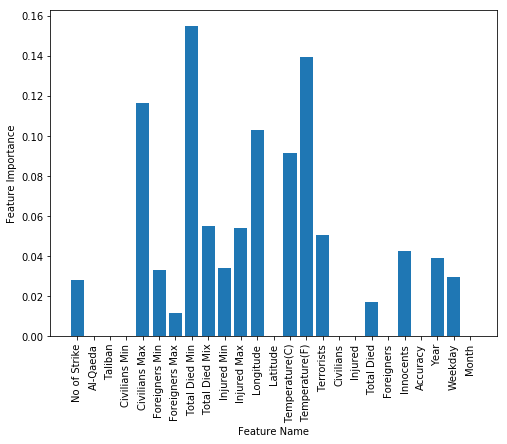

In [161]:
fi = cls.feature_importances_
x_train=train_df.drop('Women/Children  ', axis=1)
feat_names = np.array(x_train.columns.values)

# Plotting Feature_Names on X-Axis and Feature_importances on Y-Axis
plt.figure(figsize=(8,6))
plt.bar(range(len(feat_names)), fi)
plt.xticks(range(len(feat_names)), feat_names, rotation=90)
plt.xlabel('Feature Name')
plt.ylabel('Feature Importance')
plt.show()

In [312]:
from sklearn.linear_model import LinearRegression

train_byyear = data_byyear[:2015]                                 # Training on data till 2015
test_byyear = data_byyear[2016:]                                  # Testing on data from 2016

x_train_byyear = train_byyear.drop('Accuracy', axis = 1).values
y_train_byyear = train_byyear['Accuracy'].values

x_test_byyear = test_byyear.drop('Accuracy', axis = 1).values
y_test_byyear = test_byyear['Accuracy'].values

LR=LinearRegression()   # Initializing DecisionTreeClassifier
LR = LR.fit(x_train_byyear, y_train_byyear)                        # Fitting the training Data
score = LR.score(x_test_byyear, y_test_byyear)
predicted = LR.predict(x_test_byyear)

print ("Prediction score of Training Data: {}".format(LR.score(x_train_byyear, y_train_byyear)))
print ("Prediction score of Testing Data: {}".format(LR.score(x_test_byyear, y_test_byyear)))

print "\n", score, predicted

Prediction score of Training Data: 0.522461482878
Prediction score of Testing Data: -0.0186016696895

-0.0186016696895 [ 0.24912599  0.27181767]


# Combining with the data of Suicide Bombing Attacks 

### Importing the Processed data

In [313]:
%store -r s_data_byyear
%store -r s_data

result = pd.merge(s_data_byyear, data_byyear, left_index=True, right_index=True)

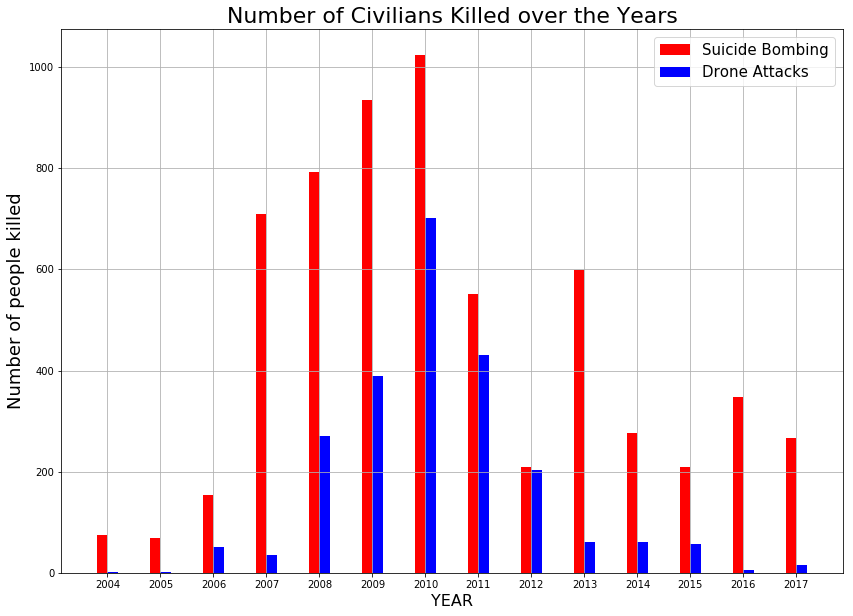

In [414]:
fig = plt.figure(figsize=(14, 10))

x = result.Terrorists.keys()

plt.bar(x - 0.1, result['Killed'], width=0.2, color='r',align='center', label = 'Suicide Bombing')
plt.bar(x + 0.1, result['Innocents'],width=0.2,color='b',align='center', label = 'Drone Attacks')
#plt.ylim(ymin=0)
plt.xticks(range(2004, 2018))
plt.xlabel("YEAR", fontsize = 16)
plt.ylabel("Number of people killed", fontsize = 18)
plt.title("Number of Civilians Killed over the Years", fontsize = 22)
plt.legend(fontsize = 15)
plt.grid()
plt.show()

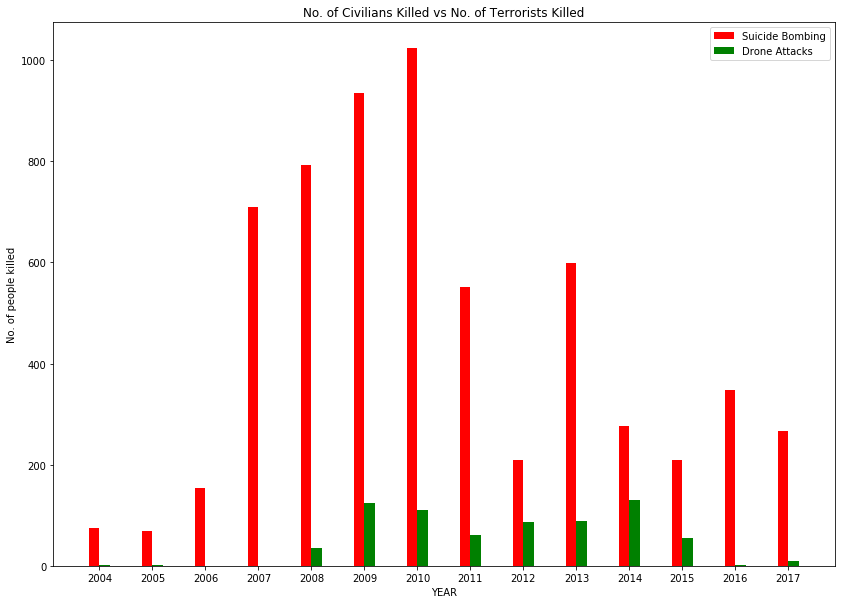

In [375]:
fig = plt.figure(figsize=(14, 10))

x = result.Terrorists.keys()

plt.bar(x - 0.1, result['Killed'], width=0.2, color='r',align='center', label = 'Suicide Bombing')
plt.bar(x + 0.1, result['Terrorists'],width=0.2,color='g',align='center', label = 'Drone Attacks')
#plt.ylim(ymin=0)
plt.xticks(range(2004, 2018))
plt.xlabel("YEAR")
plt.ylabel("No. of people killed")
plt.title("No. of Civilians Killed vs No. of Terrorists Killed")
plt.legend()
plt.show()

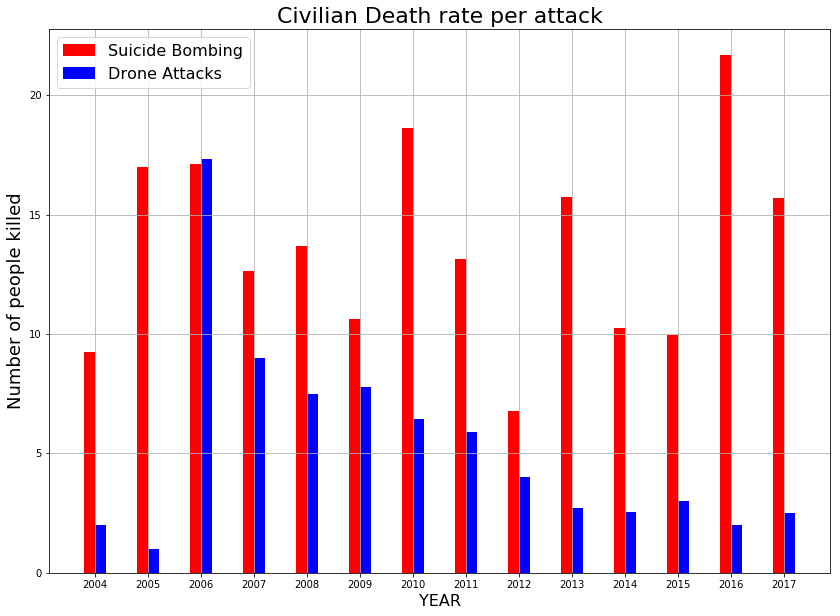

In [418]:
fig = plt.figure(figsize=(14, 10))

x = result.Terrorists.keys()

plt.bar(x - 0.1, result['Avg Civilians Killed'], width=0.2, color='r',align='center', label = 'Suicide Bombing')
plt.bar(x + 0.1, result['Avg Innocents Killed'],width=0.2,color='b',align='center', label = 'Drone Attacks')
#plt.ylim(ymin=0)
plt.xticks(range(2004, 2018))
plt.xlabel("YEAR", fontsize = 16)
plt.ylabel("Number of people killed", fontsize = 18)
plt.title("Civilian Death rate per attack", fontsize = 22)
plt.legend( fontsize = 16)
plt.grid()
plt.show()

In [364]:
data_byyear

,Terrorists,Innocents,Injured,No of strikes,Al-Qaeda,Taliban,Foreigners,Accuracy,Avg Innocents Killed
Year,,,,,,,,,
2004.0,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.333333,2.000000
2005.0,2.0,2.0,1.0,2.0,2.0,0.0,2.0,0.666667,1.000000
2006.0,0.0,52.0,2.0,3.0,0.0,0.0,0.0,0.000000,17.333333
2007.0,0.0,36.0,19.0,6.0,0.0,0.0,2.0,0.000000,9.000000
2008.0,36.0,270.0,113.0,55.0,11.0,25.0,52.0,0.075241,7.500000
2009.0,125.0,389.0,225.0,57.0,13.0,112.0,35.0,0.259694,7.780000
2010.0,111.0,701.0,285.0,123.0,1.0,110.0,53.0,0.122750,6.431193
2011.0,60.0,431.0,95.0,79.0,6.0,54.0,21.0,0.104892,5.904110
2012.0,87.0,204.0,64.0,105.0,7.0,80.0,30.0,0.231209,4.000000
